# Inspecting NetCDF data using xarray

`xarray` expands the utility of the time series analysis package `pandas` into more than one dimension. It is actively being developed in conjunction with many other packages under the [Pangeo](https://pangeo.io/) umbrella. For example, you can run with Dask to use multiple cores on your laptop when you are working with data read in with `xarray`.

## NetCDF files and other formats

NetCDF is a binary storage format for many different kinds of rectangular data. Examples include atmosphere and ocean model output, satellite images, and timeseries data. NetCDF files are intended to be device independent, and the dataset may be queried in a fast, random-access way. More information about NetCDF files can be found [here](http://www.unidata.ucar.edu/software/netcdf/). The [CF conventions](http://cfconventions.org) are used for storing NetCDF data for earth system models, so that programs can be aware of the coordinate axes used by the data cubes.

We will read in netCDF files using `xarray`; a variety of other file formats will work too.

In [1]:
#github.com/nteract/papermill'parameters'tag used to inject them into template then post a gist runable by colab
url,ext,urn=None,None,None

# Parameters
# these parameters are passed from the GeoCodes Searth interface; 
# assign default values:
url = "http://cmore.soest.hawaii.edu/cmoredata/Doney/3D/CMORE_NPAC_BEC.gx3.22.anthro.cv2.1959.nc"
ext = ""
urn = ""

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
#import cmocean.cm as cmo
import pandas as pd
import requests 
import xarray as xr
import cftime


In [3]:
def testurl(theurl):
    #try HEAD first in case the response document is big
    r = requests.head(theurl)
    if (r.status_code != requests.codes.ok):
        #check GET in case is an incomplete http implementation
        r = requests.get(theurl, stream=True)
        print('content size:', r.headers['content-length'])
        if (r.status_code == requests.codes.ok):
            return True
        else:
            print ('status code: ', r.status_code)
            return False
    else:
        return True

In [4]:
# get file-like object with .nc extension from the URL

if testurl(url):
    response = requests.get(url, allow_redirects=True)
    open('temp.nc', 'wb').write(response.content)
else:
    print('url ', url, 'not responding')

content size: 46661928


## open dataset
We'll use the `xarray` package to read this file, which has already been saved into the `data` directory.

One of the useful things about `xarray` is that it doesn't deal with the numbers in the file until it has to. This is called "lazy evaluation". It will note the operations you want done, but won't actually perform them until it needs to spit out numbers.

Viewing metadata is instantaneous since no calculations need to be done, even if the file is huge.

An xarray data object is a "dataset" or "data array".

In [5]:
ds = xr.open_dataset('temp.nc',decode_times=False)

# look at overview of metadata for file
ds

<xarray.Dataset>
Dimensions:         (time: 12, z_t: 25, z_w: 25, nlat: 16, nlon: 52)
Coordinates:
  * time            (time) float64 7.151e+05 7.151e+05 ... 7.154e+05 7.154e+05
  * z_t             (z_t) float32 400.0 1.222e+03 ... 4.255e+05 4.751e+05
  * z_w             (z_w) float32 0.0 800.0 1.644e+03 ... 4.007e+05 4.503e+05
    TLAT            (nlat, nlon) float32 ...
    TLONG           (nlat, nlon) float32 ...
Dimensions without coordinates: nlat, nlon
Data variables: (12/33)
    TAREA           (nlat, nlon) float32 ...
    HMXL            (time, nlat, nlon) float64 ...
    ATM_PRESS_USED  (time, nlat, nlon) float64 ...
    PH              (time, nlat, nlon) float64 ...
    O2SAT           (time, nlat, nlon) float64 ...
    FG_O2           (time, nlat, nlon) float64 ...
    ...              ...
    POC_FLUX_IN     (time, z_w, nlat, nlon) float64 ...
    CaCO3_FLUX_IN   (time, z_t, nlat, nlon) float64 ...
    PAR_avg         (time, z_t, nlat, nlon) float64 ...
    photoC_sp       (time, z_t, nlat, nlon) float64 ...
    photoC_diat     (time, z_t, nlat, nlon) float64 ...
    photoC_diaz     (time, z_t, nlat, nlon) float64 ...
Attributes:
    history:   Created on Thu Aug 20 14:14:41 2009\nby Ivan Lima <ivan@whoi.edu>
    contents:  Subtropical North Pacific data for case BEC.gx3.22.anthro.cv2.

In [7]:
# variables that are in our dataset
ds.data_vars

Data variables: (12/33)
    TAREA           (nlat, nlon) float32 3.491e+14 3.495e+14 ... 9.561e+14
    HMXL            (time, nlat, nlon) float64 nan 6.311e+03 ... nan nan
    ATM_PRESS_USED  (time, nlat, nlon) float64 nan 0.9986 0.9986 ... nan nan nan
    PH              (time, nlat, nlon) float64 nan 8.105 8.114 ... nan nan nan
    O2SAT           (time, nlat, nlon) float64 nan 207.0 210.6 ... nan nan nan
    FG_O2           (time, nlat, nlon) float64 nan 0.01195 0.007964 ... nan nan
    ...              ...
    POC_FLUX_IN     (time, z_w, nlat, nlon) float64 ...
    CaCO3_FLUX_IN   (time, z_t, nlat, nlon) float64 ...
    PAR_avg         (time, z_t, nlat, nlon) float64 ...
    photoC_sp       (time, z_t, nlat, nlon) float64 ...
    photoC_diat     (time, z_t, nlat, nlon) float64 ...
    photoC_diaz     (time, z_t, nlat, nlon) float64 ...

In [8]:
# dataset dimensions
ds.dims

Frozen({'time': 12, 'z_t': 25, 'z_w': 25, 'nlat': 16, 'nlon': 52})

In [9]:
# dataset coordinates
ds.coords

Coordinates:
  * time     (time) float64 7.151e+05 7.151e+05 ... 7.154e+05 7.154e+05
  * z_t      (z_t) float32 400.0 1.222e+03 2.109e+03 ... 4.255e+05 4.751e+05
  * z_w      (z_w) float32 0.0 800.0 1.644e+03 ... 3.516e+05 4.007e+05 4.503e+05
    TLAT     (nlat, nlon) float32 5.598 5.601 5.603 5.606 ... 28.77 28.67 28.57
    TLONG    (nlat, nlon) float32 100.1 103.7 107.3 110.9 ... 276.8 280.4 284.0

In [10]:
# dataset global attributes
ds.attrs

{'history': 'Created on Thu Aug 20 14:14:41 2009\nby Ivan Lima <ivan@whoi.edu>',
 'contents': 'Subtropical North Pacific data for case BEC.gx3.22.anthro.cv2.'}

In [11]:
# look at shape and units for a variable
# coppy in a variable name for {varname}
# ds.{varname}.shape, ds.{varname}.units

In [12]:
# view any of the metadata
ds.history

'Created on Thu Aug 20 14:14:41 2009\nby Ivan Lima <ivan@whoi.edu>'

## Extract numbers

Note that you can always extract the actual numbers from a called to your dataset using `.values` at the end. Be careful when you use this since it might be a lot of information. Always check the metadata without using `.values` first to see how large the arrays are you'll be reading in.

In [13]:
#pick a variable from ds.data_vars list. (put a variable name to replace  {var}
thevar = "HMXL"

In [14]:
# Extract a variable (dataarray) (put a variable name to replace  {var}
ds[thevar]

<xarray.DataArray 'HMXL' (time: 12, nlat: 16, nlon: 52)>
array([[[        nan, 6310.772949, ..., 2383.020996,         nan],
        [        nan, 7205.618652, ..., 2005.686401,         nan],
        ...,
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]],

       [[        nan, 7240.065918, ..., 1363.295044,         nan],
        [        nan, 7942.28418 , ..., 1245.391357,         nan],
        ...,
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]],

       ...,

       [[        nan, 2810.360107, ..., 2934.271484,         nan],
        [        nan, 3244.232178, ..., 2753.222412,         nan],
        ...,
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]],

       [[        nan, 4311.334473, ..., 2031.771729,         nan],
        [        nan, 4741.408203, ..., 1722.887451,         nan],
        ...,
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]]])
Coordinates:
  * time     (time) float64 7.151e+05 7.151e+05 ... 7.154e+05 7.154e+05
    TLAT     (nlat, nlon) float32 5.598 5.601 5.603 5.606 ... 28.77 28.67 28.57
    TLONG    (nlat, nlon) float32 100.1 103.7 107.3 110.9 ... 276.8 280.4 284.0
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  Mixed-Layer Depth
    units:      centimeter

In [15]:
# The actual array data
ds[thevar].data

array([[[          nan, 6310.77294922, 7921.00244141, ...,
         2082.23266602, 2383.02099609,           nan],
        [          nan, 7205.61865234, 7486.54882812, ...,
         1915.5826416 , 2005.68640137,           nan],
        [          nan, 7001.70556641, 7715.20068359, ...,
         1326.70495605, 1595.62646484,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan, 7240.06591797, 8812.953125  , ...,
         1707.08764648, 1363.29504395,           nan],
        [          nan, 7942.28417969, 8477.98730469, ...,
         1527.32519531, 1245.39135742,           nan],
        [          nan, 7784.01171875, 8712.37792969, ...,
         1254.

In [16]:
# The actual array data
ds[thevar].coords

Coordinates:
  * time     (time) float64 7.151e+05 7.151e+05 ... 7.154e+05 7.154e+05
    TLAT     (nlat, nlon) float32 5.598 5.601 5.603 5.606 ... 28.77 28.67 28.57
    TLONG    (nlat, nlon) float32 100.1 103.7 107.3 110.9 ... 276.8 280.4 284.0

In [17]:
# dataarray attributes
ds[thevar].attrs

{'long_name': 'Mixed-Layer Depth', 'units': 'centimeter'}

## Select data

Extract data from `xarray` datasets using `.sel` and `.isel`. The command strings can be long because we have multi-dimensional data now.

When files are read in, data arrays are read in as variables and the coordinates that they are in reference to are called "coordinates". For example, in the present dataset, we have the following coordinates:

In [18]:
ds.coords

Coordinates:
  * time     (time) float64 7.151e+05 7.151e+05 ... 7.154e+05 7.154e+05
  * z_t      (z_t) float32 400.0 1.222e+03 2.109e+03 ... 4.255e+05 4.751e+05
  * z_w      (z_w) float32 0.0 800.0 1.644e+03 ... 3.516e+05 4.007e+05 4.503e+05
    TLAT     (nlat, nlon) float32 5.598 5.601 5.603 5.606 ... 28.77 28.67 28.57
    TLONG    (nlat, nlon) float32 100.1 103.7 107.3 110.9 ... 276.8 280.4 284.0

We also have the following data variables, which are the main data of the file:

In [19]:
ds.data_vars

Data variables: (12/33)
    TAREA           (nlat, nlon) float32 3.491e+14 3.495e+14 ... 9.561e+14
    HMXL            (time, nlat, nlon) float64 nan 6.311e+03 ... nan nan
    ATM_PRESS_USED  (time, nlat, nlon) float64 nan 0.9986 0.9986 ... nan nan nan
    PH              (time, nlat, nlon) float64 nan 8.105 8.114 ... nan nan nan
    O2SAT           (time, nlat, nlon) float64 nan 207.0 210.6 ... nan nan nan
    FG_O2           (time, nlat, nlon) float64 nan 0.01195 0.007964 ... nan nan
    ...              ...
    POC_FLUX_IN     (time, z_w, nlat, nlon) float64 ...
    CaCO3_FLUX_IN   (time, z_t, nlat, nlon) float64 ...
    PAR_avg         (time, z_t, nlat, nlon) float64 ...
    photoC_sp       (time, z_t, nlat, nlon) float64 ...
    photoC_diat     (time, z_t, nlat, nlon) float64 ...
    photoC_diaz     (time, z_t, nlat, nlon) float64 ...

This means that we should subselect from the data variable "sst" with respect to the coordinates. We can select from none up to all of the coordinates that the sst variable is respect to. As we can see in the following cell, the variable "sst" has coordinates "lat", "lon", and "time".

In [21]:
#ds.{datavar}.coords
ds[thevar].coords

Coordinates:
  * time     (time) float64 7.151e+05 7.151e+05 ... 7.154e+05 7.154e+05
    TLAT     (nlat, nlon) float32 5.598 5.601 5.603 5.606 ... 28.77 28.67 28.57
    TLONG    (nlat, nlon) float32 100.1 103.7 107.3 110.9 ... 276.8 280.4 284.0

We'll start with a small example: let's choose a single time to plot. Here is how to choose a specific time. 
Choose one of the coordinates to select on and substitute for {thecoord} in teh cell below.

You can set method="nearest" if you aren't sure exactly what the slices are for the selected variable:

In [44]:
ds[thevar].sel(time=7.151e+05,  method="nearest")

<xarray.DataArray 'HMXL' (nlat: 16, nlon: 52)>
array([[        nan, 7240.065918, 8812.953125, ..., 1707.087646, 1363.295044,
                nan],
       [        nan, 7942.28418 , 8477.987305, ..., 1527.325195, 1245.391357,
                nan],
       [        nan, 7784.011719, 8712.37793 , ..., 1254.495483, 1188.131592,
                nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan]])
Coordinates:
    time     float64 7.151e+05
    TLAT     (nlat, nlon) float32 5.598 5.601 5.603 5.606 ... 28.77 28.67 28.57
    TLONG    (nlat, nlon) float32 100.1 103.7 107.3 110.9 ... 276.8 280.4 284.0
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  Mixed-Layer Depth
    units:      centimeter

Now let's plot it! 
This plot assumes the x axis is longitude the y axis is latitude), and substitute the appropriate coord names from your data. for {long} and {lat}. Use the selection from the previous cell as the independent variable.

Note that we are using `cartopy` to plot our maps and need to input the projection information (proj variable) for the projection appropriate to the dataset,  with the "transform" keyword argument to convert to PlateCarre projection (pc), which maps meridians to vertical straight lines of constant spacing, and circles of latitude to horizontal straight lines of constant spacing.

Documentation on functions used here:

[matplotlib pyplot module](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)

[cartopy](https://scitools.org.uk/cartopy/docs/latest/reference/index.html)

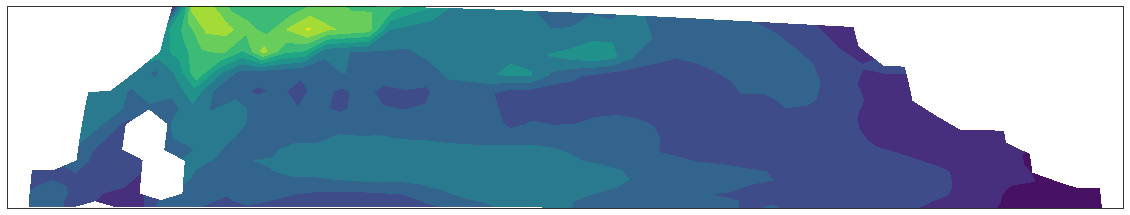

In [48]:
proj = cartopy.crs.Mollweide(central_longitude=180)
pc = cartopy.crs.PlateCarree()
#plt is matplotlib pyplot module
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111, projection=proj)
mappable = ax.contourf(ds.TLONG, ds.TLAT, ds[thevar].sel(time=7.151e+05,  method="nearest"), 10,  transform=pc)

We can either select by coordinate type, such as in the following cell where we choose all times between (and including) the years 1900 and 1950, longtitudes between 260 and 280 degrees, and latitude between 16 and 30 degrees. (substitute appropriate variable names for you dataset and uncomment to test)

In [ ]:
#ds.{variable}.sel(time=slice('1900','1950'), lon=slice(-100+360, -80+360), lat=slice(30,16))

.... or by index, such as in the following cell where we select the first index of data in terms of with time, longitude, and latitude:

In [ ]:
#ds.{variable}.isel(time=0, lon=0, lat=0)

# Calculations

You can do basic operations using `xarray`, such as take the mean. You can input the axis or axises you want to take the operation over in the function call.

In [ ]:
#ds.{variable}.mean('time')

In [ ]:
#ds.{variable}.sum(('lat','lon'))

## Loading remote data

### THREDDS example. Loading data from a remote dataset.

The netCDF library can be compiled such that it is 'THREDDS enabled', which means that you can put in a URL instead of a filename. This allows access to large remote datasets, without having to download the entire file. You can find a large list of datasets served via an OpenDAP/THREDDs server [here](http://apdrc.soest.hawaii.edu/data/data.php).

Let's look at the ESRL/NOAA 20th Century Reanalysis – Version 2. You can access the data by the following link (this is the link of the `.dds` and `.das` files without the extension.):

In [ ]:
loc = 'http://apdrc.soest.hawaii.edu/dods/public_data/Reanalysis_Data/NOAA_20th_Century/V2c/daily/monolevel/cprat'
ds2 = xr.open_dataset(loc)
ds2

In [ ]:
ds2['cprat'].long_name

In [ ]:
proj = cartopy.crs.Sinusoidal(central_longitude=180)

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111, projection=proj)
ax.coastlines(linewidth=0.25)
# use the last time available
mappable = ax.contourf(ds2.lon, ds2.lat, ds2.cprat.isel(time=-1), 20, cmap=cmo.tempo, transform=pc)
ax.set_title(pd.Timestamp(ds2.time[-1].values).isoformat()[:10])  # or use .strftime instead of .isoformat
fig.colorbar(mappable).set_label('%s' % ds2['cprat'].long_name)

---
### *Exercise*

> Pick another [variable](http://apdrc.soest.hawaii.edu/dods/public_data/Reanalysis_Data/esrl/daily/monolevel) from this dataset. Inspect and plot the variable in a similar manner to precipitation.

> Find another dataset on a THREDDS server at SOEST (or elsewhere), pick a variable, and plot it.

---

Note that you can also just plot against the included coordinates with built-in convenience functions (this is analogous to `pandas` which was for one dimension). The sst is being plotted against longitude and latitude, which is flattening it out.

In [ ]:
ds.sst.sel(time='1954-6-1').plot()#transform=pc)  # the plot's projection

In [ ]:
proj = cartopy.crs.Mollweide(central_longitude=180)
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111, projection=proj)
ds.sst.sel(time='1954-6-1').plot(transform=pc)  # the plot's projection

## GroupBy

Like in `pandas`, we can use the `groupby` method to do some neat things. Let's group by season and save a new file.

In [ ]:
seasonal_mean = ds.groupby('time.season').mean('time')
seasonal_mean

## Saving NetCDF files

Creating netCDF files is tedious if doing it from scratch, but it is very easy when starting from data that has been read in using `xarray`.

In [ ]:
fname = 'test.nc'
seasonal_mean.to_netcdf(fname)

In [ ]:
xr.open_dataset(fname)

---
### *Exercise*

> Plot the difference between summer and winter mean sea surface temperature.

---